# Birth-Death Process Examples

This notebook demonstrates a linear birth-death process with the Gillespie algorithm.

We then compare trajectories for different birth rates $\lambda$ (at fixed death rate $\mu$) to visualize time evolution.

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using MonteCarloX
using StatsBase
using Plots

  Activating project at `~/.julia/dev/MonteCarloX/notebooks`
Precompiling packages...
   1058.8 ms  ✓ MonteCarloX
   1587.4 ms  ✓ SpinSystems
  2 dependencies successfully precompiled in 5 seconds. 218 already precompiled.


In [2]:
mutable struct BirthDeathProcess <: AbstractSystem
    N::Int
    λ::Float64
    μ::Float64
    rates::Vector{Float64}

    function BirthDeathProcess(N0::Int, λ::Float64, μ::Float64)
        rates = [λ * N0, μ * N0]
        new(N0, λ, μ, rates)
    end
end

function modify!(sys::BirthDeathProcess, event::Int)
    if event == 1
        sys.N += 1
    elseif event == 2
        sys.N -= 1
    end
    sys.rates[1] = sys.λ * sys.N
    sys.rates[2] = sys.μ * sys.N
    return nothing
end

modify! (generic function with 1 method)

In [3]:
rng = MersenneTwister(42)
sys = BirthDeathProcess(10, 0.42, 0.4)
alg = Gillespie(rng) # initialized at time 0

T = 100.0
measurements = Measurements([
    :population => (s -> s.N) => Float64[]
], collect(0:0.5:T))

measure!(measurements, sys, alg.time)

while alg.time <= T && sys.N > 0
    t_new, event = step!(alg, sys.rates)
    if event === nothing || !isfinite(t_new)
        break
    end
    # time is auto-updated by the algorithm
    measure!(measurements, sys, alg.time)
    modify!(sys, event)
end

population_data = measurements[:population].data
println("Linear process summary:")
println("  final population = $(sys.N)")
println("  sampled events   = $(alg.steps)")
println("  mean population  = $(round(mean(population_data), digits=2))")

Linear process summary:
  final population = 0
  sampled events   = 182
  mean population  = 12.35


## Time Evolution for Different λ

In [4]:
function simulate_birth_death_trajectory(N0, λ, μ, T; seed=1)
    rng = MersenneTwister(seed)
    sys = BirthDeathProcess(N0, λ, μ)
    alg = Gillespie(rng) # initialized at time 0

    measurements = Measurements([
        :population => (s -> s.N) => Float64[]
    ], collect(0:0.5:T))

    while alg.time <= T && sys.N > 0
        t_new, event = step!(alg, sys.rates)
        if event === nothing || !isfinite(t_new)
            break
        end
        measure!(measurements, sys, alg.time)
        modify!(sys, event)
    end

    measure!(measurements, sys, T)

    return measurements
end

simulate_birth_death_trajectory (generic function with 1 method)

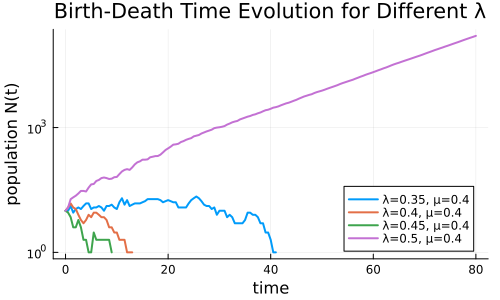

In [ ]:
N0 = 10
μ = 0.4
Tplot = 80.0
lambdas = [0.35, 0.40, 0.45, 0.50]

plt = plot(
    xlabel = "time",
    ylabel = "population N(t)",
    title = "Birth-Death Time Evolution for Different λ",
    legend = :bottomright,
    yscale = :log10,
    size = (500, 300)
 )

for (i, λ) in enumerate(lambdas)
    measurements = simulate_birth_death_trajectory(N0, λ, μ, Tplot; seed=100+i)
    t = MonteCarloX.times(measurements)
    y = MonteCarloX.data(measurements, :population)
    idx = y .> 0
    plot!(plt, t[idx], y[idx], label="λ=$(λ), μ=$(μ)", lw=2)
end

plt